In [6]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [7]:
import GPUtil
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [26]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import os
from torchmetrics import F1Score

In [9]:
random_seed = 12
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [10]:
train_dir_path = '/opt/ml/input/data/train/'
train_image_path = '/opt/ml/input/data/train/images/'

dt_train = pd.read_csv(train_dir_path+'train.csv')
len(dt_train)

2700

In [11]:
def get_age_range(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2

In [12]:
dt_train['age_range'] = dt_train['age'].apply(lambda x : get_age_range(x))

In [98]:
over_sixty = dt_train.loc[dt_train['age_range']==2,:]

,id,gender,race,age,path,age_range
31,39,female,Asian,60,000039_female_Asian_60,2
65,224,female,Asian,60,000224_female_Asian_60,2
70,229,male,Asian,60,000229_male_Asian_60,2
75,237,male,Asian,60,000237_male_Asian_60,2
94,267,male,Asian,60,000267_male_Asian_60,2
...,...,...,...,...,...,...
2168,5453,female,Asian,60,005453_female_Asian_60,2
2173,5459,male,Asian,60,005459_male_Asian_60,2
2175,5461,female,Asian,60,005461_female_Asian_60,2
2209,5504,female,Asian,60,005504_female_Asian_60,2


In [172]:
for idx in tqdm(range(len(over_sixty))):
    path = over_sixty.iloc[idx]['path']
    os.mkdir(train_image_path+path+'_1')
    os.mkdir(train_image_path+path+'_2')
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        img = Image.open(train_image_path+path+'/'+file_name)
        img1 = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5)(img)
        img2 = torchvision.transforms.GaussianBlur(9, 4)(img)       
        img1.save(train_image_path+path+'_1'+'/'+file_name, 'JPEG')      
        img2.save(train_image_path+path+'_2'+'/'+file_name, 'JPEG')

In [175]:
path1 = []
path2 = []
for i in range(len(over_sixty)):
    path1.append(over_sixty.iloc[i]['path'] + '_1')
    path2.append(over_sixty.iloc[i]['path'] + '_2')

In [188]:
over_sixty_1 = pd.DataFrame({'id':over_sixty['id'], 'gender':over_sixty['gender'], 'race':over_sixty['race'], 'path':path1, 'age_range':over_sixty['age_range']})
over_sixty_2 = pd.DataFrame({'id':over_sixty['id'], 'gender':over_sixty['gender'], 'race':over_sixty['race'], 'path':path2, 'age_range':over_sixty['age_range']})

In [192]:
dt_train = dt_train.append(over_sixty_1, ignore_index=True)
dt_train = dt_train.append(over_sixty_2, ignore_index=True)
dt_train

,id,gender,race,age,path,age_range
0,1,female,Asian,45.0,000001_female_Asian_45,1
1,2,female,Asian,52.0,000002_female_Asian_52,1
2,4,male,Asian,54.0,000004_male_Asian_54,1
3,5,female,Asian,58.0,000005_female_Asian_58,1
4,6,female,Asian,59.0,000006_female_Asian_59,1
...,...,...,...,...,...,...
3113,5453,female,Asian,NaN,005453_female_Asian_60_2,2
3114,5459,male,Asian,NaN,005459_male_Asian_60_2,2
3115,5461,female,Asian,NaN,005461_female_Asian_60_2,2
3116,5504,female,Asian,NaN,005504_female_Asian_60_2,2


In [193]:
train_idx, valid_idx = train_test_split(np.arange(len(dt_train)),
                                       test_size=0.2,
                                       shuffle=True,
                                       stratify=dt_train['age_range'])

In [194]:
train_image = []
train_label = []

for idx in train_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        train_image.append(train_image_path+path+'/'+file_name)
        train_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))                

In [195]:
valid_image = []
valid_label = []

for idx in valid_idx:
    path = dt_train.iloc[idx]['path']
    for file_name in [i for i in os.listdir(train_image_path+path) if i[0] != '.']:
        valid_image.append(train_image_path+path+'/'+file_name)
        valid_label.append((path.split('_')[1], path.split('_')[3], file_name.split('.')[0]))            

In [196]:
def onehot_enc(x):
    def gender(i):
        if i == 'male':
            return 0
        elif i == 'female':
            return 3
    def age(j):
        j = int(j)
        if j < 30:
            return 0
        elif j >= 30 and j < 60:
            return 1
        elif j >= 60:
            return 2
    def mask(k):
        if k == 'normal':
            return 12
        elif 'incorrect' in k:
            return 6
        else:
            return 0
    return gender(x[0]) + age(x[1]) + mask(x[2])

In [197]:
train_data = pd.Series(train_image)
train_label = pd.Series(train_label)

valid_data = pd.Series(valid_image)
valid_label = pd.Series(valid_label)

In [198]:
class Dataset_Mask(Dataset):
    def __init__(self, data, label, encoding=True, midcrop=True, transform=None):
        self.encoding = encoding
        self.midcrop = midcrop
        self.data = data
        self.label = label
        self.transform = transform
        
        if encoding:
            self.label = self.label.apply(onehot_enc)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X = cv2.cvtColor(cv2.imread(self.data[idx]), cv2.COLOR_BGR2RGB)
        y = self.label[idx]
        
        if self.midcrop:
            X = X[70:420, 17:367]
        
        if self.transform:
            return self.transform(X), y
        return X, y

In [199]:
mask_train_set = Dataset_Mask(data=train_data, label=train_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))
mask_val_set = Dataset_Mask(data=valid_data, label=valid_label, transform = transforms.Compose([
                                transforms.ToTensor()
                            ]))

In [200]:
print(f'training data size : {len(mask_train_set)}')
print(f'validation data size : {len(mask_val_set)}')

training data size : 17458
validation data size : 4368


In [202]:
t_image = [mask_train_set[i][1] for i in tqdm(range(len(mask_train_set)))]
v_image = [mask_val_set[i][1] for i in tqdm(range(len(mask_val_set)))]

In [204]:
t_df = pd.DataFrame(t_image, columns=['counts'])
v_df = pd.DataFrame(v_image, columns=['counts'])

Text(0.5, 0, 'valid set labels')

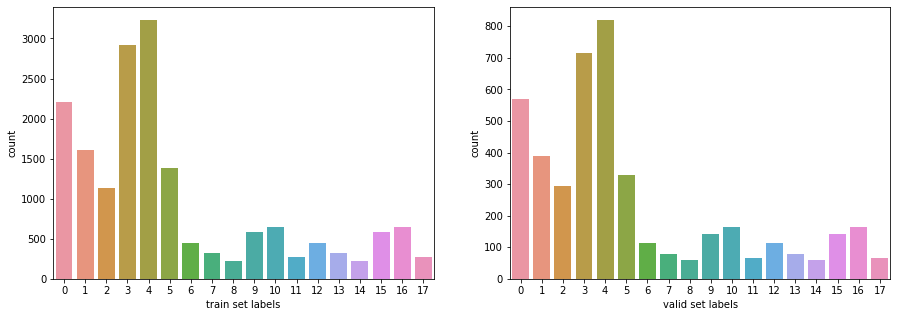

In [205]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x='counts', data=t_df, ax=axes[0])
axes[0].set_xlabel("train set labels")
sns.countplot(x='counts', data=v_df, ax=axes[1])
axes[1].set_xlabel("valid set labels")

In [2]:
import shutil
shutil.make_archive('/opt/ml/images_aug', 'zip', '/opt/ml/input/data/train/images')

'/opt/ml/images_aug.zip'